In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())) + "/..")
if os.getcwd().endswith("Topic2"):
    os.chdir("..")
    print(f"Changed to {os.getcwd()}")

from codebase import(
    load_excel, 
    load_odin_as_ml_dataset, 
    plot_confusion_matrix, 
    make_ml_dataset, 
    run_binary_regression, 
    transport_modes, 
    trip_motives, 
    province_codes, 
    transport_mode_col, 
    IGNORE_RULES, 
    apply_ignore_rules,
    number_of_sub_trips_col,
    )

Changed to c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation


In [2]:
years = [2019, 2020, 2021, 2022, 2023]
dfs = []
for year in years:
    odin_excel_path = os.path.join(os.getcwd(), "data", "OdiN 2019-2023", f"OdiN {year}", f"ODiN{year}_Databestand.csv")
    if year in [2019, 2020]:
        odin_excel_path = odin_excel_path.replace("Databestand", "Databestand_v2.0")
    df = load_excel(odin_excel_path)
    df = apply_ignore_rules(df, IGNORE_RULES)   # <<–– new line

    dfs.append(df[df[number_of_sub_trips_col] == 1])  # Filter for single sub-trips

df_all = pd.concat(dfs, ignore_index=True)

Loaded file from CSV
Loaded file from CSV
Loaded file from CSV
Loaded file from CSV
Loaded file from CSV


In [4]:
df_all

,Variabele_naam_ODiN_2019,Variabele_label_ODiN_2019,Niveau \nP = persoon; \nV = verplaatsing;\nR = rit; \nW = weegfactor,Code_ODiN_2019,Code_label_ODiN_2019,Korte_omschrijving,OP,OPID,Steekproef,Mode,...,BerHalte,RdHalteA,RdHalteB,BerFam,RdFamA,RdFamB,BerSport,RdSportA,RdSportB,HerkLand
0,OP,Nieuwe persoon,P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,0,Geen nieuwe persoon,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,1,Nieuwe persoon,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OPID,Uniek id voor iedere OP,P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,id,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786999,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.799999e+11,1.0,1.0,...,1.0,13.0,13.0,1.0,13.0,13.0,1.0,13.0,13.0,1.0
787000,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.799999e+11,1.0,1.0,...,1.0,13.0,13.0,1.0,13.0,13.0,1.0,13.0,13.0,1.0
787001,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.799999e+11,1.0,1.0,...,1.0,13.0,13.0,1.0,13.0,13.0,1.0,13.0,13.0,1.0
787002,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.799999e+11,1.0,1.0,...,1.0,13.0,13.0,1.0,13.0,13.0,1.0,13.0,13.0,1.0


In [ ]:
len(df), len(df["OPID"].unique())

In [ ]:
len(df_all) / df_all["VertPC"].unique().shape[0]

In [ ]:
# Create a histogram for the number of trips for each transport mode and translate to 
df[transport_mode_col].value_counts().plot(kind="bar", title="Number of trips per transport mode")

In [ ]:
for val, name in transport_modes.items():
    print(f"Number of {name}: ({len(df[df[transport_mode_col] == val])})")

In [ ]:
print(transport_modes)

In [ ]:
print(trip_motives)

In [ ]:
print(province_codes)

In [ ]:
df_all.columns

Now a classifier that classifies what mode of transport was used

In [5]:
print(transport_modes)

{1: 'Passenger car', 2: 'Train', 3: 'Bus', 4: 'Tram', 5: 'Metro', 6: 'Speed pedelec', 7: 'Electric bicycle', 8: 'Non-electric bicycle', 9: 'On foot', 10: 'Touring car', 11: 'Delivery van', 12: 'Truck', 13: 'Camper', 14: 'Taxi/Minibus', 15: 'Agricultural vehicle', 16: 'Motorcycle', 17: 'Moped', 18: 'Light moped', 19: 'Mobility aid with motor', 20: 'Mobility aid without motor', 21: 'Skates/inline skates/kick scooter', 22: 'Boat', 23: 'Other with motor', 24: 'Other without motor'}


Common labels: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23.]


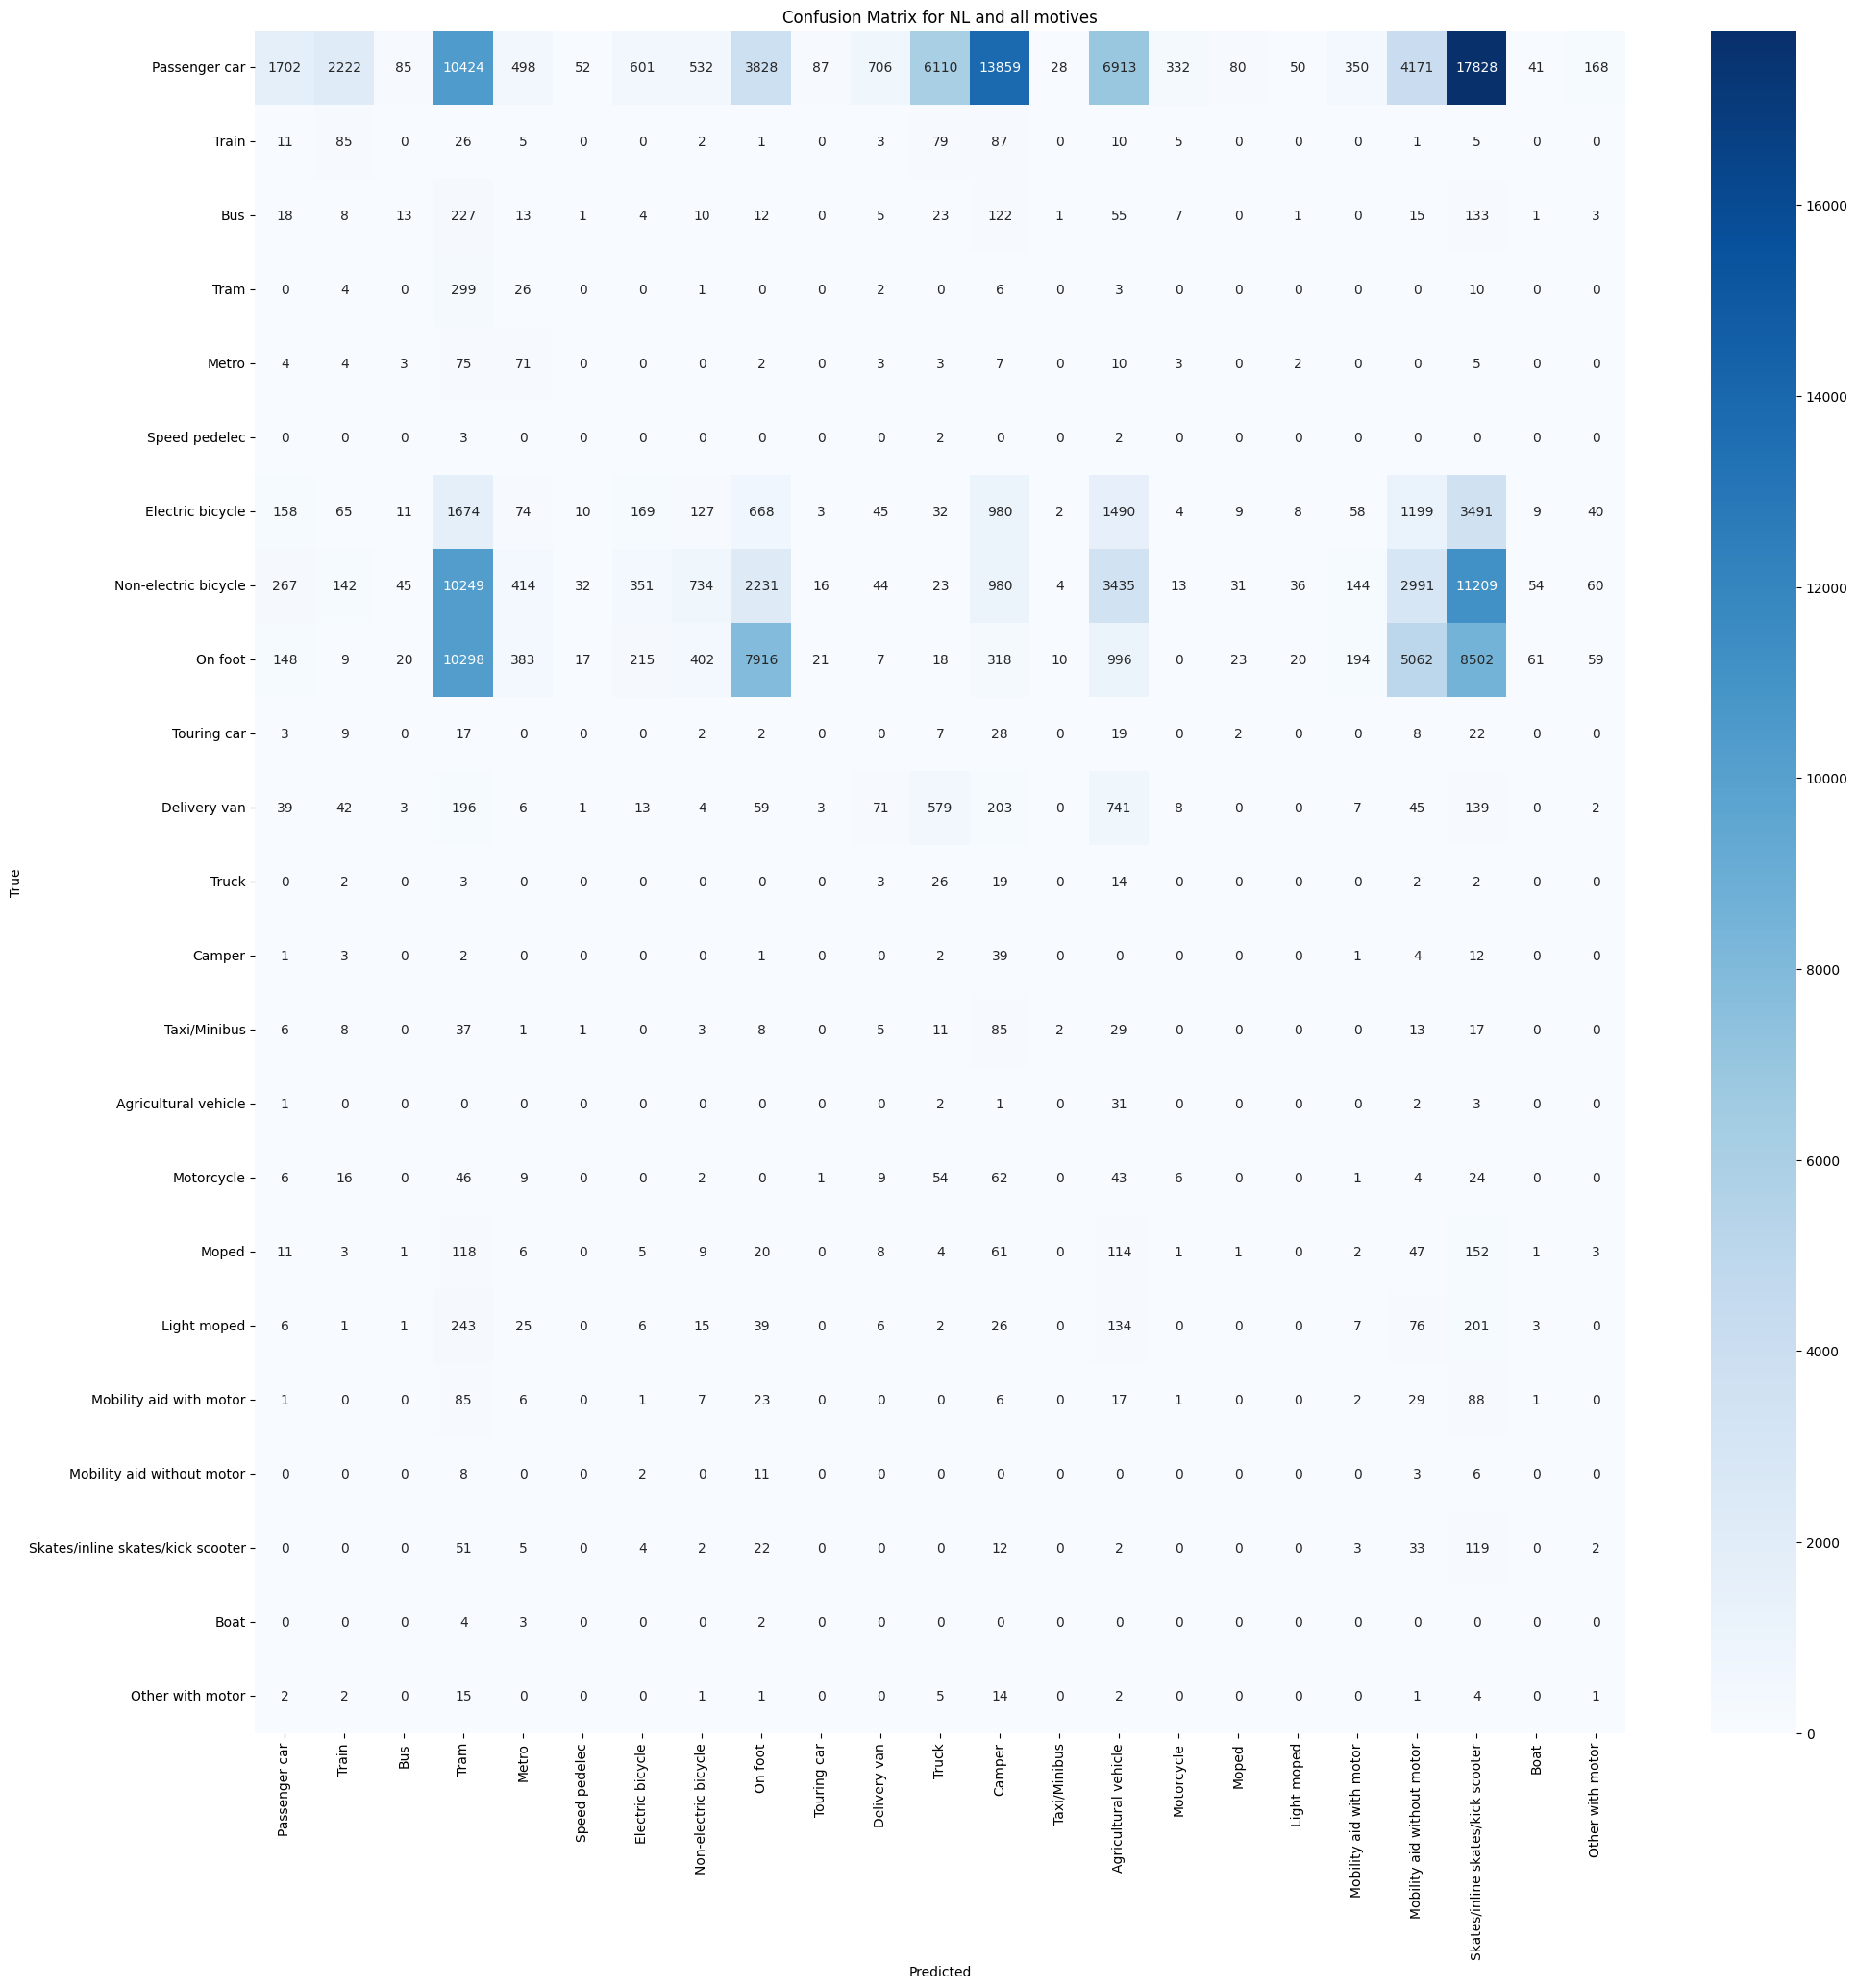

                                   precision    recall  f1-score   support

                    Passenger car       0.71      0.02      0.05     70667
                            Train       0.03      0.27      0.06       320
                              Bus       0.07      0.02      0.03       672
                             Tram       0.01      0.85      0.02       351
                            Metro       0.05      0.37      0.08       192
                    Speed pedelec       0.00      0.00      0.00         7
                 Electric bicycle       0.12      0.02      0.03     10326
             Non-electric bicycle       0.40      0.02      0.04     33505
                          On foot       0.53      0.23      0.32     34699
                      Touring car       0.00      0.00      0.00       119
                     Delivery van       0.08      0.03      0.05      2161
                            Truck       0.00      0.37      0.01        71
                        

In [7]:
from codebase import run_multiclass_classification, distance_col, origin_col, province_codes, level_mapping_suffix, age_col, transport_mode_col, motive_col, urbanness_col


df_multiclass = df_all[df_all[transport_mode_col] != df_all[transport_mode_col].max()]
motives=None
origins=None#[7, 8, ]
location_level=2
categorical_features=[origin_col]
numerical_features=[distance_col, urbanness_col, motive_col]
origin_str = ', '.join(province_codes[code] for code in origins) if origins is not None else "NL"
motive_str = ', '.join(trip_motives[motive] for motive in motives) if motives is not None else "all motives"

_ = run_multiclass_classification(
    df_multiclass,
    test_size=0.2,
    destinations=None,
    origins=origins,
    location_level=location_level,
    categorical_features=categorical_features,
    numerical_features=numerical_features,
    motives=motives,
    plot=True,
    savename=f"graphics/classification_results/multiclass/{level_mapping_suffix[location_level]}/{origins}/{motives}/{categorical_features + numerical_features}",
    plot_title=f"Confusion Matrix for {origin_str} and {motive_str}",
)

In [ ]:
from codebase import urbanness_col, motive_col

age_range = (0, np.inf)

df_less_vehicles = df_multiclass[df_multiclass[transport_mode_col].isin(vehicles_to_include)]
df_less_vehicles = df_less_vehicles[(df_less_vehicles[age_col] < age_range[1]) & (df_less_vehicles[age_col] > age_range[0])]

motives=None
origins=None#[7, 8, ]
location_level=2
categorical_features=[origin_col]
numerical_features=[distance_col, urbanness_col, motive_col]
origin_str = ', '.join(province_codes[code] for code in origins) if origins is not None else "NL"

model_multiclass, _ = run_multiclass_classification(
    df_less_vehicles,
    test_size=0.2,
    destinations=None,
    origins=origins,
    location_level=location_level,
    categorical_features=categorical_features,
    numerical_features=numerical_features,
    motives=motives,
    plot=True,
    savename=f"graphics/classification_results/multiclass/{level_mapping_suffix[location_level]}/{origins}/less_vehicles/age_{age_range[0]}_{age_range[1]}/{categorical_features + numerical_features}",
    plot_title=f"Confusion Matrix for {origin_str} by {', '.join(transport_modes[tm] for tm in vehicles_to_include)}",
)

In [ ]:
# Include a subset af transport modes to compare the bike to

run_binary_regression(
        df_less_vehicles[df_less_vehicles[transport_mode_col].isin([1, 8,])],
        test_size=0.2,
        transport_modes_predict=[8, ],
        motives=motives,
        max_dist=max_dist,
        savename=f"graphics/classification_results/binary_regression/car_foot_and_bike/{transport_modes[transport_mode].replace(r'/', ' or ')}_{max_dist}",
    )